In [1]:
from graphMatching import *
from networkx import read_edgelist
from scipy.io import loadmat
from model import *
from utils import *

In [2]:
# import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

In [3]:
def test_matching(truth, test):
	matching = []
	test = test.tolist()
	truth = truth.tolist()

	for item in test:
		if item in truth:
			matching.append(item)
	return matching

# build graph
def build_graph(adj_norm):
	edges = adj_norm.coalesce().indices()

	G = nx.from_edgelist(edges.T.cpu().numpy())
	G.remove_edges_from(nx.selfloop_edges(G))
	print(G.number_of_nodes(), G.number_of_edges())

	return G

def plot_match(G1, G2, matching):
	pos1 = nx.spring_layout(G1)
	pos2 = nx.spring_layout(G2)

	plt.figure(figsize=(16, 8))
	ax1 = plt.subplot(1, 2, 1)
	plt.title('Graph 1')
	nx.draw_networkx(G1, pos=pos1, font_color="w")
	ax2 = plt.subplot(1, 2, 2)
	plt.title('Graph 2')
	nx.draw_networkx(G2, pos=pos2, font_color="w")

	# add connections
	for i in range(len(matching)):
		con = ConnectionPatch(xyA=pos1[matching[i][0]], xyB=pos2[matching[i][1]], coordsA=ax1.transData, coordsB=ax2.transData, arrowstyle="-", color="green")
		ax2.add_artist(con)
	plt.show()

def matrix_to_edge(X):
	indices = []
	row, col = X.shape
	for i in range(row):
		for j in range(col):
			if X[i][j] == 1:
				indices.append([i, j])
	option = np.array(indices)
	option = option[option[:, 1].argsort()]
	print(option.shape)
	return option

def heatmap():
	plt.matshow(X, cmap='Blues')
	plt.show()

def complete_to_square(matrix, pad_value=0):
    rows, cols = matrix.shape
    
    if rows == cols:
        # The matrix is already square
        return matrix
    
    # Determine the size of the new square matrix
    max_dim = max(rows, cols)
    
    # Create a new matrix with the pad_value
    square_matrix = np.full((max_dim, max_dim), pad_value)
    
    # Copy the original matrix into the top-left corner of the new square matrix
    square_matrix[:rows, :cols] = matrix
    
    return square_matrix

def edge_to_matrix(D, edges):
	m, n = D.shape
	matrix = np.zeros((m, n))

	for i in range(min(m, n)):
		matrix[edges[i][0]][edges[i][1]] = 1
	return matrix

In [4]:
data = "ACM_DBLP" # args.dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
train_features = {}
if (data == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	input_dim = 17
	b = np.load('data/ACM-DBLP.npz')
	train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b['test_pairs'].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = 1024
	output_feature_size = 1024
	lr = 0.0001
	epoch = 100
elif (data == "Douban Online_Offline"):
	a1, f1, a2, f2, test_pairs = load_douban()
	f1 = f1.A
	f2 = f2.A
	train_set = ["Online", "Offline"]
	input_dim = 538
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	train_features["Online"] = [torch.from_numpy(f1).float()]
	train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = 512
	output_feature_size = 512
	lr = 0.0001
	epoch = 100


In [5]:
""" temp = torch.from_numpy(b["x1"]).float() # G1, features
print(temp.shape)
temp """

' temp = torch.from_numpy(b["x1"]).float() # G1, features\nprint(temp.shape)\ntemp '

In [6]:
""" temp = torch.from_numpy(b["x2"]).float() # G2, features
print(temp.shape)
temp """

' temp = torch.from_numpy(b["x2"]).float() # G2, features\nprint(temp.shape)\ntemp '

In [7]:
""" temp = b["test_pairs"]
print(temp.shape)
temp """

' temp = b["test_pairs"]\nprint(temp.shape)\ntemp '

In [8]:
test_pairs

array([[   0, 6829],
       [   2, 3102],
       [   3, 3584],
       ...,
       [9841, 3392],
       [9850,  306],
       [9868, 9011]], dtype=int32)

In [9]:
train_set

['ACM', 'DBLP']

In [10]:
encoder = "GIN"
use_input_augmentation = True
use_output_augmentation = False
print("Loading training datasets")
train_loader = {}
for dataset in train_set:
	train_loader[dataset] = [load_adj(dataset)]

train_loader

Loading training datasets


{'ACM': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])],
 'DBLP': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])]}

In [11]:
train_loader.keys()

dict_keys(['ACM', 'DBLP'])

In [12]:
""" temp = train_loader["ACM"][0]
print(temp.shape)
temp """

' temp = train_loader["ACM"][0]\nprint(temp.shape)\ntemp '

In [13]:
""" temp = train_loader["DBLP"][0]
print(temp.shape)
temp """

' temp = train_loader["DBLP"][0]\nprint(temp.shape)\ntemp '

In [14]:
model = GAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size, activation=F.relu,
			use_input_augmentation=use_input_augmentation,
			use_output_augmentation=use_output_augmentation,
			encoder=encoder).to(device)
model

GAE(
  (base_gcn): GIN(
    (in_proj): Linear(in_features=17, out_features=1024, bias=True)
    (convs): ModuleList(
      (0-13): 14 x GINConv(
        (linear): Linear(in_features=1041, out_features=1024, bias=True)
      )
    )
    (out_proj): Linear(in_features=15360, out_features=1024, bias=True)
  )
)

In [15]:
print("Generating training features")


Generating training features


In [16]:
train_loader

{'ACM': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])],
 'DBLP': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])]}

In [17]:
print("Fitting model")
# fit_GAE_real(data, len(train_set) * (1 + 1), model, epoch, train_loader, train_features, device, lr,test_pairs)
# fit_GAE_real(data, no_samples, GAE, epoch, train_loader, train_features, device, lr, test_pairs):

no_samples = len(train_set) * (1 + 1)
GAE = model
# ---

best_hitAtOne = 0
best_hitAtFive = 0
best_hitAtTen = 0
best_hitAtFifty = 0
optimizer = Adam(GAE.parameters(), lr=lr, weight_decay=5e-4)

for step in tqdm(range(epoch)):
	loss = 0
	
	for dataset in train_loader.keys():
		S = train_loader[dataset][0]
		initial_features = train_features[dataset]
		
		for i in range(len(train_loader[dataset])):
			adj_tensor = train_loader[dataset][i]
			adj = coo_matrix(adj_tensor.numpy())
			adj_norm = preprocess_graph(adj)
			pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
			norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

			adj_label = coo_matrix(S.numpy())
			adj_label = sparse_to_tuple(adj_label)

			adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
												torch.FloatTensor(adj_norm[1]),
												torch.Size(adj_norm[2])).to(device)
			adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
												torch.FloatTensor(adj_label[1]),
												torch.Size(adj_label[2])).to(device)

			initial_feature = initial_features[i].to(device)

			weight_mask = adj_label.to_dense().view(-1) == 1
			weight_tensor = torch.ones(weight_mask.size(0))
			weight_tensor[weight_mask] = pos_weight
			weight_tensor = weight_tensor.to(device)
			z = GAE(initial_feature, adj_norm)
			A_pred = torch.sigmoid(torch.matmul(z,z.t()))
			loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
														weight=weight_tensor)
	
	optimizer.zero_grad()
	loss = loss / no_samples
	loss.backward()
	optimizer.step()

	# ---
	keys = list(train_loader.keys())
	S1 = train_loader[keys[0]][0]
	S2 = train_loader[keys[1]][0]
	
	adj_S1 = coo_matrix(S1.numpy())
	adj_norm_1 = preprocess_graph(adj_S1)
	adj_norm_1 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_1[0].T),
											torch.FloatTensor(adj_norm_1[1]),
											torch.Size(adj_norm_1[2])).to(device)
	adj_S2 = coo_matrix(S2.numpy())
	adj_norm_2 = preprocess_graph(adj_S2)
	adj_norm_2 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_2[0].T),
											torch.FloatTensor(adj_norm_2[1]),
											torch.Size(adj_norm_2[2])).to(device)
	if (data == "ACM_DBLP"):
		S1_feat = train_features["ACM"][0]
		S2_feat = train_features["DBLP"][0]
	elif (data == "Douban Online_Offline"):
		S1_feat = train_features["Online"][0]
		S2_feat = train_features["Offline"][0]

	# ---
	S1_emb = GAE(S1_feat.to(device), adj_norm_1).detach()
	S2_emb = GAE(S2_feat.to(device), adj_norm_2).detach()

	D = torch.cdist(S1_emb, S2_emb, 2) # Euclidean distance
	
	if (data == "ACM_DBLP"):
		test_idx = test_pairs[:, 0].astype(np.int32)
		labels = test_pairs[:, 1].astype(np.int32)
	elif (data == "Douban Online_Offline"):
		test_idx = test_pairs[0, :].astype(np.int32)
		labels = test_pairs[1, :].astype(np.int32)
	
	hitAtOne = 0
	hitAtFive = 0
	hitAtTen = 0
	hitAtFifty = 0
	hitAtHundred = 0
	
	# test
	
	for i in range(len(test_idx)): # here
		dist_list = D[test_idx[i]]
		# print(i, test_idx[i], dist_list)
		sorted_neighbors = torch.argsort(dist_list).cpu()
		label = labels[i]
		
		""" if i == 0:
			print(label, sorted_neighbors[0].item(), sorted_neighbors)
			# 6829 6829 tensor([6829, 3102,  601,  ..., 7878, 9701, 2044]) """
		
		for j in range(100):
			if (sorted_neighbors[j].item() == label):
				if (j == 0):
					hitAtOne += 1
					hitAtFive += 1
					hitAtTen += 1
					hitAtFifty += 1
					hitAtHundred += 1
					break
				elif (j <= 4):
					hitAtFive += 1
					hitAtTen += 1
					hitAtFifty += 1
					hitAtHundred += 1
					break
				elif (j <= 9):
					hitAtTen += 1
					hitAtFifty += 1
					hitAtHundred += 1
					break
				elif (j <= 49):
					hitAtFifty += 1
					hitAtHundred += 1
					break
				elif (j <= 100):
					hitAtHundred += 1
					break
	
	cur_hitAtOne = hitAtOne / len(test_idx)
	cur_hitAtFive = hitAtFive / len(test_idx)
	cur_hitAtTen = hitAtTen / len(test_idx)
	cur_hitAtFifty = hitAtFifty / len(test_idx)

	if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
	if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
	if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
	if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

print("The best results achieved:")
print("Hit@1: ", end="")
print(best_hitAtOne)
print("Hit@5: ", end="")
print(best_hitAtFive)
print("Hit@10: ", end="")
print(best_hitAtTen)
print("Hit@50: ", end="")
print(best_hitAtFifty)

Fitting model


100%|██████████| 100/100 [05:25<00:00,  3.26s/it]

The best results achieved:
Hit@1: 0.7367588932806324
Hit@5: 0.9140316205533597
Hit@10: 0.9511857707509881
Hit@50: 0.9814229249011858


In [21]:
print(D.shape)
D

torch.Size([9872, 9916])


tensor([[18.1416, 19.1218, 17.8377,  ..., 18.3232, 18.0194, 17.8191],
        [16.2521, 15.4908, 15.8528,  ..., 16.4086, 16.1201, 15.9282],
        [21.2098, 21.8529, 20.9663,  ..., 21.3654, 20.9915, 20.8664],
        ...,
        [ 2.3890,  4.5315,  1.3241,  ...,  3.6745,  2.3560,  1.8829],
        [ 2.0933,  4.6594,  1.9884,  ...,  3.5906,  1.9376,  0.4439],
        [ 1.9008,  4.7192,  1.8870,  ...,  3.5870,  1.6204,  1.3088]],
       device='cuda:0')

Truth

In [23]:
print(data)
print(test_pairs.shape)
print(test_pairs)

ACM_DBLP
(5060, 2)
[[   0 6829]
 [   2 3102]
 [   3 3584]
 ...
 [9841 3392]
 [9850  306]
 [9868 9011]]


In [20]:
if (data == "ACM_DBLP"):
	test_pairs_ = test_pairs
elif (data == "Douban Online_Offline"):
	test_pairs_ = test_pairs.T
	
truth = test_pairs_[test_pairs_[:, 1].argsort()]
print(truth.shape)
truth

(5060, 2)


array([[3615,    1],
       [1302,    2],
       [ 466,    3],
       ...,
       [6148, 9907],
       [3826, 9911],
       [7275, 9915]], dtype=int32)

In [22]:
truth_ = test_pairs_[test_pairs_[:, 0].argsort()]
print(truth_.shape)
truth
_

(5060, 2)


tensor([[18.1416, 19.1218, 17.8377,  ..., 18.3232, 18.0194, 17.8191],
        [16.2521, 15.4908, 15.8528,  ..., 16.4086, 16.1201, 15.9282],
        [21.2098, 21.8529, 20.9663,  ..., 21.3654, 20.9915, 20.8664],
        ...,
        [ 2.3890,  4.5315,  1.3241,  ...,  3.6745,  2.3560,  1.8829],
        [ 2.0933,  4.6594,  1.9884,  ...,  3.5906,  1.9376,  0.4439],
        [ 1.9008,  4.7192,  1.8870,  ...,  3.5870,  1.6204,  1.3088]],
       device='cuda:0')

#### Option 0

In [ ]:
def hungarian(D):
	print("0")
	P = torch.zeros_like(D)
	matrix = D.tolist()
	m = Munkres()
	print("1")
	indexes = m.compute(matrix)
	print("2")
	total = 0
	for r, c in tqdm(indexes):
		print(r)
		P[r][c] = 1
		total += matrix[r][c]
	return P.t()

X = hungarian(D)
print(X.shape)
# online_offline: 215m
# acm_dblp: 2112m
X

In [ ]:
# save

X = X.cpu().numpy()
np.save("P_hungarian_ACM_DBLP", X)

In [ ]:
# load

X = np.load("P_hungarian.npy")
X

In [ ]:
option0 = []
m, n = X.shape
for i in range(m):
	for j in range(n):
		if X[i][j] == 1:
			option0.append([j, i]) # S, S_hat
option0 = np.array(option0)
print(len(option0))
option0

In [ ]:
matching = test_matching(truth, option0)
print(len(matching))
print(len(matching) / len(truth))
matching

#### Option 1

In [29]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def hungarian_algorithm(cost_matrix):
	# Use the linear_sum_assignment method from scipy
	row_ind, col_ind = linear_sum_assignment(cost_matrix)
	
	# Total cost
	total_cost = cost_matrix[row_ind, col_ind].sum()
	
	# The assignments are returned as (row, col) pairs
	assignments = list(zip(row_ind, col_ind))
	
	return total_cost, assignments

total_cost, assignments = hungarian_algorithm(D.cpu())

NameError: name 'D' is not defined

In [26]:
option1 = np.array(assignments)
option1 = option1[option1[:, 1].argsort()]
print(option1.shape)
option1

(9872, 2)


array([[2985,    0],
       [3615,    1],
       [1637,    2],
       ...,
       [2873, 9913],
       [8202, 9914],
       [7276, 9915]])

In [27]:
matching = test_matching(truth, option1)
print(len(matching))
print(len(matching) / len(truth))
matching

3449
0.6816205533596837


[[3615, 1],
 [466, 3],
 [1971, 4],
 [685, 9],
 [5778, 11],
 [4103, 12],
 [7144, 14],
 [3608, 15],
 [1928, 18],
 [3708, 20],
 [1304, 23],
 [3382, 28],
 [1141, 29],
 [480, 31],
 [2369, 33],
 [7672, 38],
 [2437, 39],
 [1624, 41],
 [279, 42],
 [4986, 43],
 [610, 46],
 [6660, 59],
 [9066, 60],
 [3513, 62],
 [7322, 65],
 [7778, 67],
 [1625, 68],
 [526, 70],
 [4932, 71],
 [566, 72],
 [1602, 77],
 [3787, 78],
 [4798, 82],
 [344, 83],
 [1322, 84],
 [5151, 87],
 [5731, 88],
 [4019, 94],
 [1475, 97],
 [7869, 98],
 [2067, 100],
 [7975, 105],
 [1108, 106],
 [4160, 107],
 [5080, 109],
 [2530, 110],
 [738, 114],
 [5234, 115],
 [1981, 118],
 [408, 126],
 [1608, 127],
 [6379, 136],
 [9661, 137],
 [730, 141],
 [2384, 143],
 [597, 154],
 [6635, 156],
 [364, 157],
 [2438, 158],
 [135, 162],
 [839, 164],
 [1421, 168],
 [6376, 175],
 [3841, 179],
 [1420, 180],
 [3508, 182],
 [5235, 183],
 [2871, 194],
 [1149, 195],
 [2924, 196],
 [6168, 199],
 [7241, 200],
 [6696, 201],
 [6352, 202],
 [6697, 203],
 [1159, 2

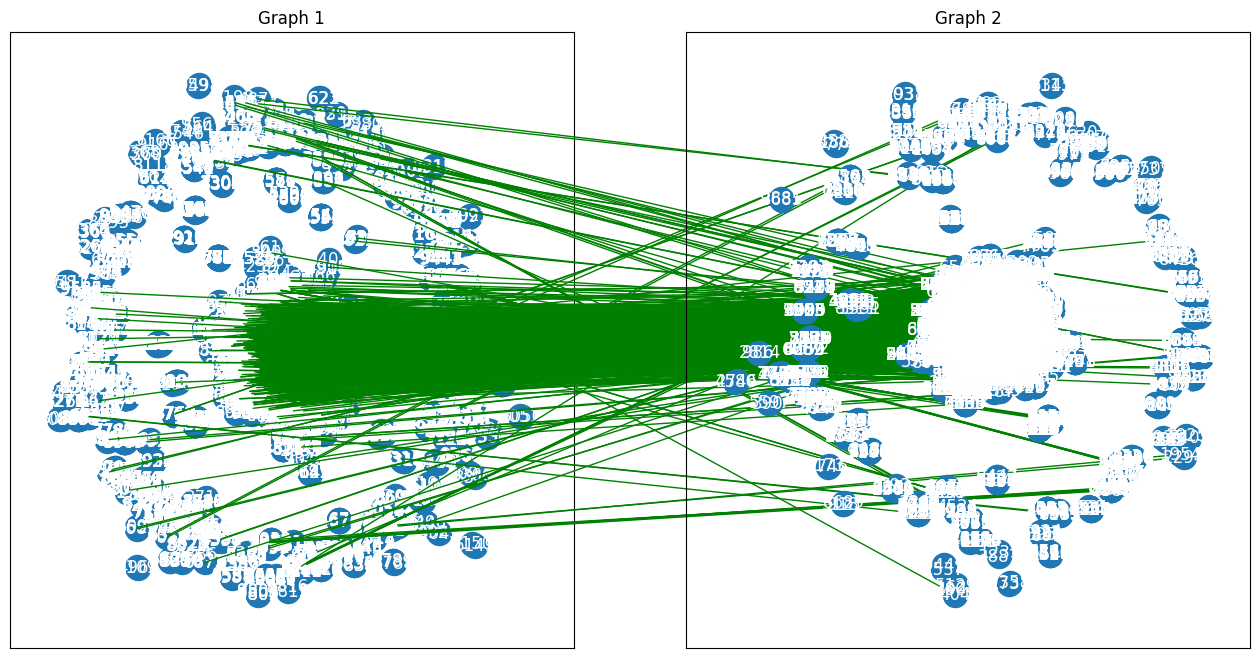

In [31]:
G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)

plot_match(G1, G2, matching)

#### Option 2

In [32]:
import pygmtools as pygm

X = pygm.hungarian(D.cpu().numpy())
print(X.shape)
X

(9872, 9916)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
option2 = matrix_to_edge(X)
option2

(9872, 2)


array([[5897,    0],
       [9704,    1],
       [1248,    2],
       ...,
       [6411, 9913],
       [3738, 9914],
       [6294, 9915]])

In [35]:
matching = test_matching(truth, option2)
print(len(matching))
print(len(matching) / len(truth))
matching

0
0.0


[]

In [ ]:
G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching)

#### Option 3

In [57]:
indices = []
for i in range(D.shape[0]):
	dist_list = D[i]
	sorted_neighbors = torch.argsort(dist_list).cpu()
	indices.append([i, sorted_neighbors[0]])

option3 = np.array(indices)
option3 = option3[option3[:, 1].argsort()]
print(option3.shape)
option3

(9872, 2)


array([[2985,    0],
       [8494,    1],
       [3615,    1],
       ...,
       [7920, 9911],
       [3826, 9911],
       [2873, 9913]])

In [58]:
matching = test_matching(truth, option3)
print(len(matching))
print(len(matching) / len(truth))
matching

3428
0.6774703557312253


[[3615, 1],
 [1302, 2],
 [466, 3],
 [1971, 4],
 [2855, 7],
 [685, 9],
 [5778, 11],
 [4103, 12],
 [3608, 15],
 [1928, 18],
 [7646, 21],
 [1304, 23],
 [3382, 28],
 [1141, 29],
 [480, 31],
 [9099, 32],
 [1181, 35],
 [7672, 38],
 [2437, 39],
 [1624, 41],
 [279, 42],
 [610, 46],
 [5633, 47],
 [6788, 54],
 [6660, 59],
 [9066, 60],
 [3513, 62],
 [7322, 65],
 [7778, 67],
 [1625, 68],
 [526, 70],
 [4932, 71],
 [566, 72],
 [3808, 73],
 [1602, 77],
 [3787, 78],
 [4798, 82],
 [344, 83],
 [1322, 84],
 [7413, 86],
 [5151, 87],
 [5731, 88],
 [4019, 94],
 [1475, 97],
 [7869, 98],
 [2067, 100],
 [2244, 104],
 [7975, 105],
 [1108, 106],
 [4160, 107],
 [5080, 109],
 [2530, 110],
 [738, 114],
 [5234, 115],
 [1981, 118],
 [408, 126],
 [1608, 127],
 [6180, 131],
 [6379, 136],
 [9661, 137],
 [7440, 139],
 [2207, 140],
 [730, 141],
 [2384, 143],
 [3171, 146],
 [5862, 147],
 [3997, 148],
 [4691, 151],
 [597, 154],
 [6635, 156],
 [364, 157],
 [2438, 158],
 [135, 162],
 [839, 164],
 [1421, 168],
 [3841, 179],
 [

9872 39561
9916 44808


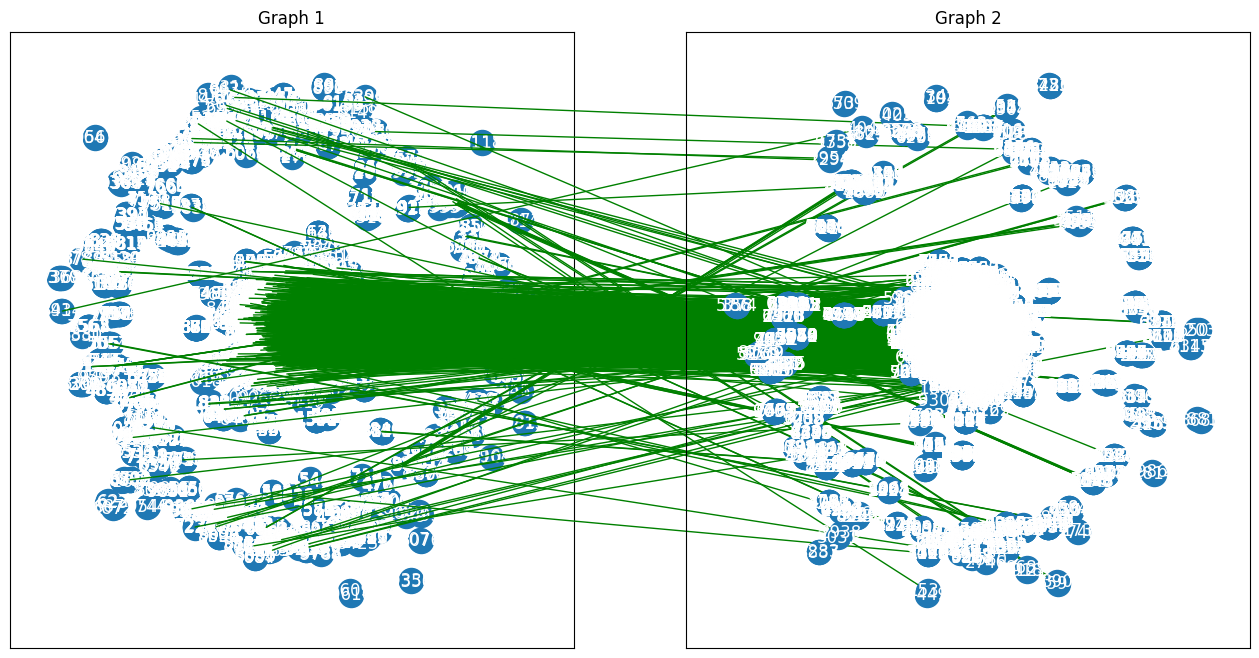

In [38]:
G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching)

#### Option 4

In [59]:
X = greedy_match(D)
X = X.todense()
X = np.array(X)
print(X.shape)
print(X)

(9872, 9916)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [61]:
option4 = matrix_to_edge(X)
option4

(9872, 2)


array([[7941,    0],
       [7985,    1],
       [8029,    2],
       ...,
       [7809, 9913],
       [1263, 9914],
       [7052, 9915]])

In [67]:
matching = test_matching(truth, option4)
print(len(matching))
print(len(matching) / len(truth))
matching

0
0.0


[]

In [ ]:
G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching)

#### Option 5

In [78]:
D_ = complete_to_square(D.cpu(), pad_value=100.0)
print(D_.shape)
D_

(9916, 9916)


array([[ 18.12713623,  19.0946331 ,  17.86019135, ...,  18.30815315,
         17.9715538 ,  17.85440636],
       [ 16.59934807,  15.82097816,  16.16613007, ...,  16.72093582,
         16.42987442,  16.33003235],
       [ 21.92976952,  22.5468502 ,  21.78345299, ...,  22.064394  ,
         21.71507263,  21.69908333],
       ...,
       [100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ]])

In [79]:
X = get_match(torch.tensor(D_), device)
print(X.shape)
X

torch.Size([9916, 9916])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [80]:
option5 = matrix_to_edge(X)
option5

(9916, 2)


array([[6829,    0],
       [ 601,    1],
       [3102,    2],
       ...,
       [9013, 9913],
       [9208, 9914],
       [9211, 9915]])

In [81]:
matching = test_matching(truth, option5)
print(len(matching))
print(len(matching) / len(truth))
matching

0
0.0


[]

In [ ]:
G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching)

---

In [ ]:
a = torch.tensor([[0.0,  0.0], [0.0, 1.0], [0.0,  2.0]])
print(a)
b = torch.tensor([[0.0, 1.0 ], [1.0,  1.0]])
print(b)
torch.cdist(a, b, p=2)

In [ ]:
a = torch.tensor([[4.01, 3.0, 2.0, 0.1, 4.0]])
print(a)
torch.argsort(a, dim=1)

In [ ]:
a = np.array([[9, 2, 3],
			  [4, 5, 6],
			  [7, 0, 5]])

a[a[:, 2].argsort()]